In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch.nn.utils.spectral_norm as spectral_norm
from scipy.spatial.distance import pdist, squareform

# Set random seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

class Config:
    SEED = 42
    WINDOW_SIZE = 12  # Adjust based on data frequency
    BATCH_SIZE = 32
    EPOCHS = 50
    PATIENCE = 10
    LEARNING_RATE = 0.001
    FEATURE_DIM = 2  # Latitude, Longitude
    HIDDEN_DIM = 64
    NUM_HEADS = 4
    DROPOUT = 0.2

config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [7]:
# Load data
footfall_path = '/Users/goffy/Desktop/CASA0004/ex3_transport/StationFootfall_Merged_2019-2023.csv'
coords_path = '/Users/goffy/Desktop/CASA0004/ex3_transport/station_coords.csv'

df_footfall = pd.read_csv(footfall_path)
df_coords = pd.read_csv(coords_path)

# --- Data Cleaning ---
print("Cleaning data...")
# 1. Convert Date
df_footfall['TravelDate'] = pd.to_datetime(df_footfall['TravelDate'])

# 2. Drop Duplicates
df_footfall = df_footfall.drop_duplicates()

# 3. Calculate Total Traffic
df_footfall['TotalTraffic'] = df_footfall['EntryTapCount'] + df_footfall['ExitTapCount']

# 4. Remove Negative Values
df_footfall = df_footfall[df_footfall['TotalTraffic'] >= 0]

# Drop stations with missing coordinates
df_coords = df_coords.dropna(subset=['latitude', 'longitude'])

# Preprocess footfall
# Aggregate by date and station (sum of Entry and Exit)
df_pivot = df_footfall.pivot_table(index='TravelDate', columns='Station', values='TotalTraffic', fill_value=0)

# 5. Remove Inactive Stations (Zero Variance)
df_pivot = df_pivot.loc[:, df_pivot.var() > 0]
print(f"Stations after cleaning: {df_pivot.shape[1]}")

# Filter stations that exist in both datasets
common_stations = sorted(list(set(df_pivot.columns) & set(df_coords['Station'])))
df_pivot = df_pivot[common_stations]
df_coords = df_coords[df_coords['Station'].isin(common_stations)].set_index('Station').reindex(common_stations)

print(f"Number of stations: {len(common_stations)}")
print(f"Time steps: {len(df_pivot)}")

# Create Adjacency Matrix based on distance
coords = df_coords[['latitude', 'longitude']].values
dist_matrix = squareform(pdist(coords, metric='euclidean'))
sigma = np.mean(dist_matrix)
adj_matrix = np.exp(-dist_matrix**2 / (2 * sigma**2))
adj_tensor = torch.FloatTensor(adj_matrix).to(device)

# External Features (Coordinates)
external_features = torch.FloatTensor(coords).to(device) # [num_nodes, 2]

Cleaning data...
Stations after cleaning: 436
Number of stations: 414
Time steps: 1826


In [8]:
# --- Save Merged Data for GCN-LSTM (Wide Format) ---
# Transpose pivot table so Stations are rows and Dates are columns
df_wide = df_pivot.T

# Merge with station coordinates (df_coords is indexed by Station)
# We want: Station, latitude, longitude, date1, date2, ...
df_final = df_coords[['latitude', 'longitude']].join(df_wide)

# Reset index to make Station the first column
df_final = df_final.reset_index()

# Save to CSV
output_path = '/Users/goffy/Desktop/CASA0004/ex3_transport/merged_transport_data_wide.csv'
df_final.to_csv(output_path, index=False)
print(f"Successfully saved wide format data to: {output_path}")
print(f"Shape: {df_final.shape}")
# Display first few columns to verify format
print(df_final.iloc[:, :6].head())

Successfully saved wide format data to: /Users/goffy/Desktop/CASA0004/ex3_transport/merged_transport_data_wide.csv
Shape: (414, 1829)
           Station   latitude  longitude  2019-01-01 00:00:00  \
0   Abbey Road DLR  51.532541   0.003609                644.0   
1       Abbey Wood  51.490696   0.111278               2672.0   
2    Acton Central  51.508716  -0.262807               1851.0   
3  Acton Main Line  51.516979  -0.267983                174.0   
4       Acton Town  51.502705  -0.279964               7162.0   

   2019-01-02 00:00:00  2019-01-03 00:00:00  
0               1390.0               1490.0  
1               7412.0               8538.0  
2               4013.0               4142.0  
3                695.0                720.0  
4              13338.0              14109.0  


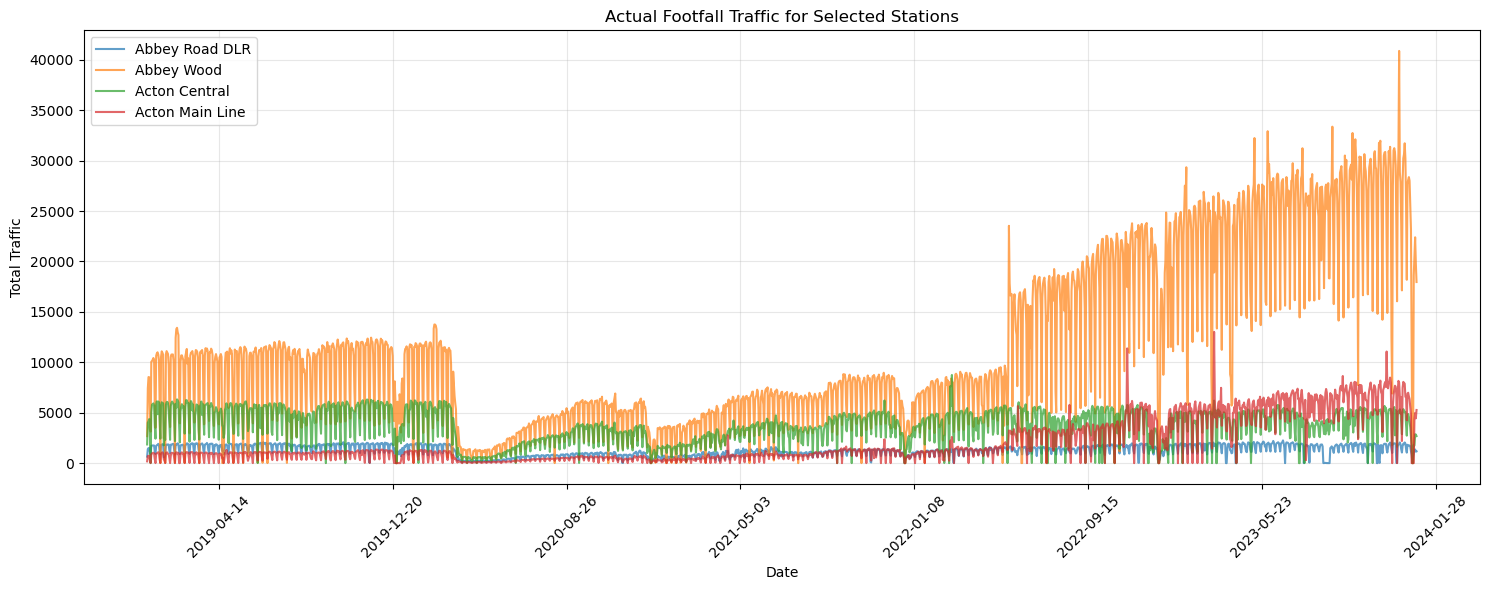

In [9]:
# Select a few stations to plot (e.g., first 4 stations)
stations_to_plot = df_pivot.columns[:4]

plt.figure(figsize=(15, 6))
for station in stations_to_plot:
    plt.plot(df_pivot.index, df_pivot[station], label=station, alpha=0.7)

plt.title('Actual Footfall Traffic for Selected Stations')
plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks to be readable (showing every nth label)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

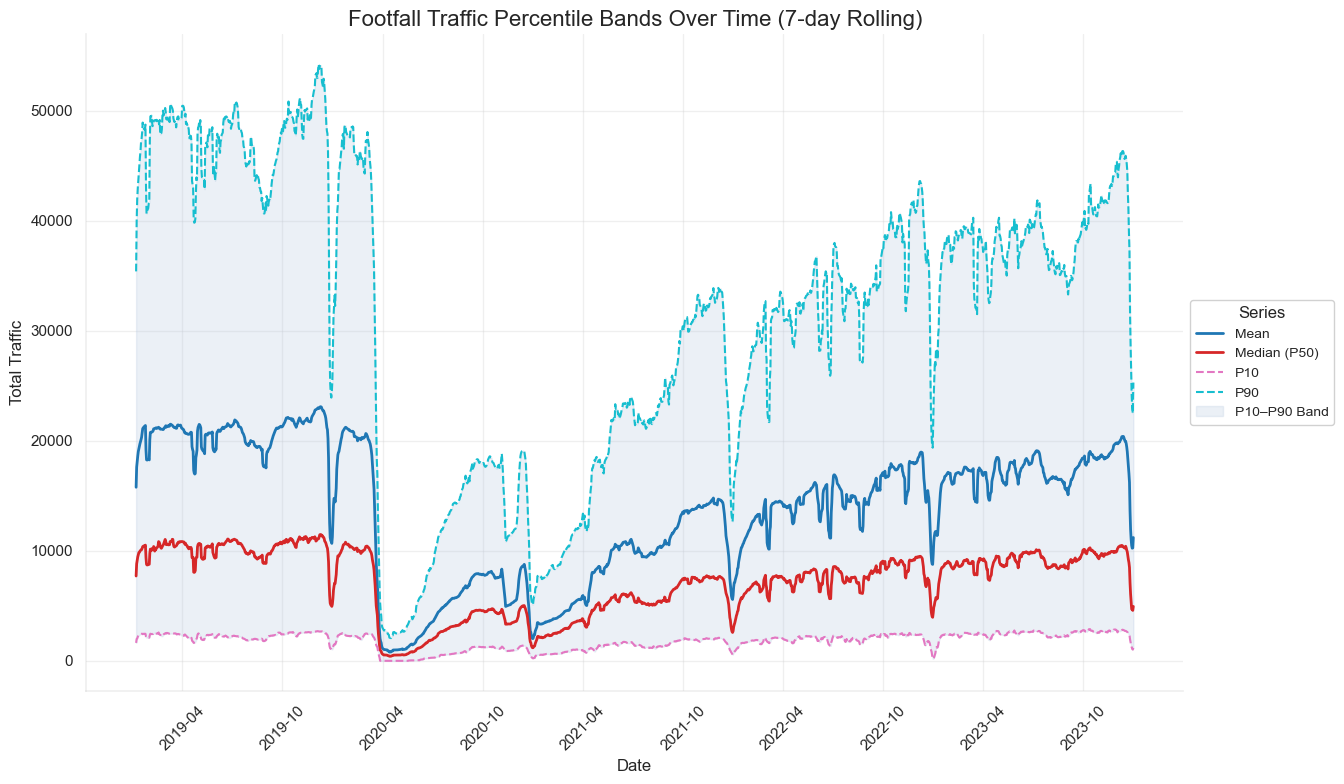

/var/folders/wb/gskmj0qx18q4nbm5tq4v7hlc0000gn/T/ipykernel_10617/2499993599.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decile_counts.index, y=decile_counts.values, palette='viridis', ax=ax)


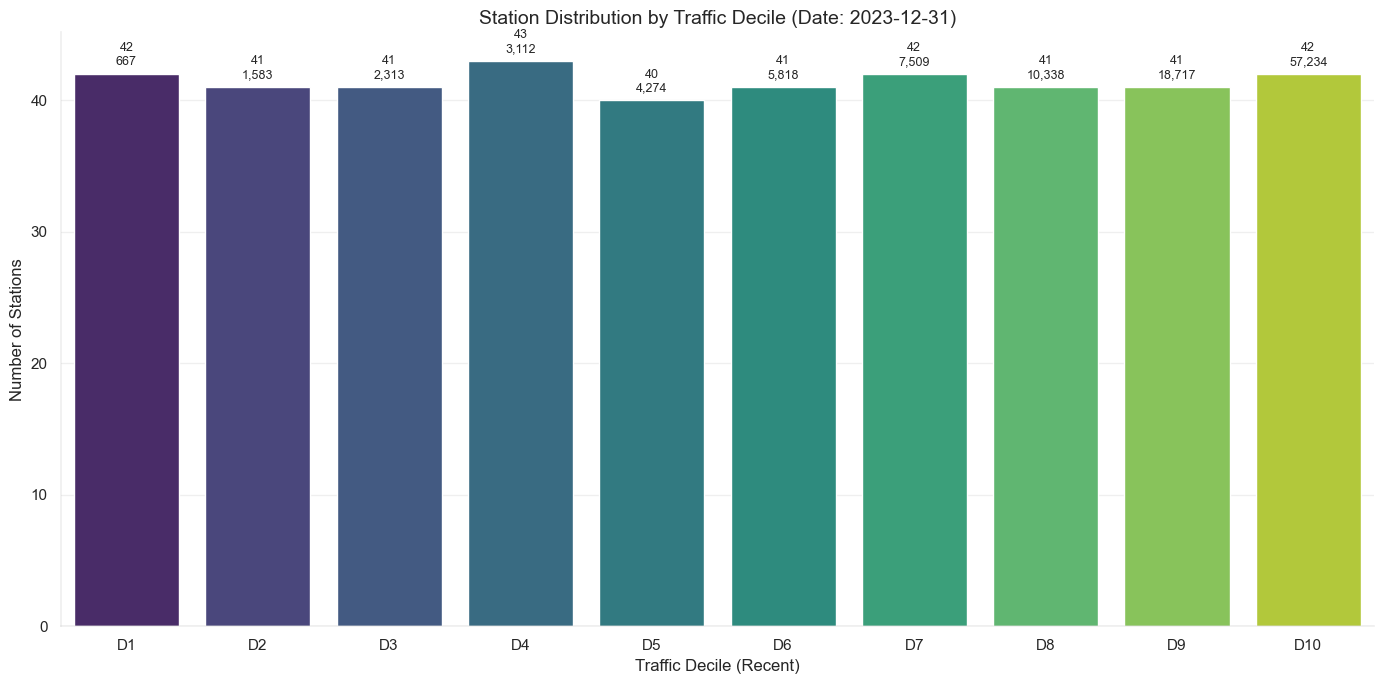

In [10]:
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set style from reference
sns.set_theme(style='whitegrid')

# Convert index to datetime if it's not already
if not isinstance(df_pivot.index, pd.DatetimeIndex):
    df_pivot.index = pd.to_datetime(df_pivot.index)

# Calculate 7-day rolling average (maintain smoothing)
df_rolling = df_pivot.rolling(window=7).mean()

# --- Prepare percentile time series ---
# Calculate statistics across all stations (axis=1) for each date
percentile_df = pd.DataFrame()
percentile_df['mean'] = df_rolling.mean(axis=1)
percentile_df['p10'] = df_rolling.quantile(0.10, axis=1)
percentile_df['p50'] = df_rolling.quantile(0.50, axis=1)
percentile_df['p90'] = df_rolling.quantile(0.90, axis=1)

# Plot selected percentile/mean lines
fig, ax = plt.subplots(figsize=(16, 8))

lines_order = ['mean', 'p50', 'p10', 'p90']
labels_map = {
    'mean': 'Mean',
    'p50': 'Median (P50)',
    'p10': 'P10',
    'p90': 'P90'
}
colors = plt.cm.tab10(np.linspace(0, 1, len(lines_order)))

for i, key in enumerate(lines_order):
    ax.plot(percentile_df.index, percentile_df[key], label=labels_map[key],
            linewidth=2 if key in ['mean', 'p50'] else 1.5,
            linestyle='-' if key in ['mean', 'p50'] else '--',
            color=colors[i])

# Fill only P10–P90 band
ax.fill_between(percentile_df.index, percentile_df['p10'], percentile_df['p90'],
                color='lightsteelblue', alpha=0.25, label='P10–P90 Band')

ax.set_title('Footfall Traffic Percentile Bands Over Time (7-day Rolling)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Traffic', fontsize=12)
ax.grid(True, alpha=0.3)

# Date Axis Formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Lighten spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_alpha(0.3)

leg = ax.legend(title='Series', fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.9)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# --- Recent traffic decile distribution (bar chart) ---
# Use the last valid timestamp from rolling data
recent_series = df_rolling.iloc[-1].dropna()

if len(recent_series) > 0:
    # Calculate decile edges
    decile_edges = np.percentile(recent_series, np.arange(0, 110, 10))
    decile_edges[0] -= 1e-6 # Ensure min is included
    
    # Handle potential duplicate edges if data is sparse or has many zeros
    if len(np.unique(decile_edges)) < len(decile_edges):
        print("Note: Duplicate decile edges detected (likely many zero values). Using rank-based qcut instead.")
        decile_cats = pd.qcut(recent_series, q=10, labels=[f'D{d}' for d in range(1, 11)], duplicates='drop')
        decile_labels = decile_cats.cat.categories
    else:
        decile_labels = [f'D{d}' for d in range(1, 10)] + ['D10']
        decile_cats = pd.cut(recent_series, bins=decile_edges, labels=decile_labels, include_lowest=True)

    decile_counts = decile_cats.value_counts().reindex(decile_labels, fill_value=0)
    # Calculate mean traffic for each decile
    decile_means = recent_series.groupby(decile_cats, observed=True).mean().reindex(decile_labels)

    fig, ax = plt.subplots(figsize=(14, 7))

    sns.barplot(x=decile_counts.index, y=decile_counts.values, palette='viridis', ax=ax)
    ax.set_ylabel('Number of Stations', fontsize=12)
    ax.set_xlabel('Traffic Decile (Recent)', fontsize=12)
    ax.set_title(f'Station Distribution by Traffic Decile (Date: {df_rolling.index[-1].date()})', fontsize=14)
    ax.grid(True, axis='y', alpha=0.3)

    for i, dec in enumerate(decile_counts.index):
        cnt = decile_counts.iloc[i]
        mean_val = decile_means.iloc[i]
        if pd.isna(mean_val): mean_val = 0
        ax.text(i, cnt + 0.01 * decile_counts.max(),
                f'{cnt:,}\n{mean_val:,.0f}',
                ha='center', va='bottom', fontsize=9)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_alpha(0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No valid recent data available to build decile distribution.")